In [2]:
import numpy as np
import pandas as pd
#for Kmeans clustering
from sklearn import cluster
from sklearn.cluster import KMeans
from datetime import datetime
from datetime import date
#for text pre-processing
import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn import preprocessing
#for word embedding
#"conda install -c conda-forge genism" or pip install genism
import gensim
from gensim.models import Word2Vec
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
# for minibatch kmenas clustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

In [3]:
df = pd.read_csv("GitHub_Projects.csv")
#reading project metadata from github projects
#getting number of days the project been created and last updated
updated = pd.to_datetime(df["updated_at"]).dt.date
created = pd.to_datetime(df["created_at"]).dt.date
days = updated-created
days = pd.to_numeric(days.dt.days, downcast='integer')
df["updated-created"] = days 
data1 = df[["stargazers_count", "forks_count", "num_model_file", "updated-created"]]
data0 = df[["id","stargazers_count", "forks_count", "num_model_file", "updated-created", "Description"]]

data0 = data0.rename(columns={"id":"FILE_ID"})
data0.head()
# data0.describe()

,FILE_ID,stargazers_count,forks_count,num_model_file,updated-created,Description
0,789683,0,7,3,2459,An ECAN library for the dsPIC33f in both C and...
1,919495,4,18,22,3085,TrueTime is a Matlab/Simulink-based simulator ...
2,4608325,7,5,11,2684,Simulink (Embedded Coder) Target for TI LaunchPad
3,4790726,1,0,1,545,Access Joysticks in Simulink on OSX
4,5480060,27,17,2,2415,An Open Source Software Package that enables o...


In [4]:
df_GitHub_Metric = pd.read_csv("GitHub_Metric.csv")
df_GitHub_Metric = df_GitHub_Metric[['FILE_ID', 'is_Lib', 'SCHK_Block_count', 'Agg_SubSystem_count', 'Hierarchy_depth', 'LibraryLinked_Count', 'CComplexity', 'total_ConnH_cnt']]
#all values are -1 when is_lib=1, so select only is_lib==0
df_GitHub_Metric = df_GitHub_Metric[df_GitHub_Metric.is_Lib == 0]
df_GitHub_Metric1 = df_GitHub_Metric.groupby('FILE_ID').agg({'SCHK_Block_count':'sum', 
                                                            'Agg_SubSystem_count':'sum', 
                                                            'Hierarchy_depth':'max', 
                                                            'LibraryLinked_Count': 'sum',
                                                            'CComplexity' :'sum',
                                                            'total_ConnH_cnt': 'sum'
                                                           }).reset_index()

df_GitHub_Metric1.describe()
df_GitHub_Metric1.head()


,FILE_ID,SCHK_Block_count,Agg_SubSystem_count,Hierarchy_depth,LibraryLinked_Count,CComplexity,total_ConnH_cnt
0,789683,50,11,3,6,-2,33
1,919495,967,152,3,83,-13,957
2,4608325,401,58,3,20,45,249
3,5480060,3,0,1,1,-1,1
4,5791243,3,0,1,1,-1,1


In [5]:
result = pd.merge(data0, df_GitHub_Metric1, on = ["FILE_ID"])
result.to_csv("metrics_and_projects_numeric_data.csv")
result.head()
data2 = result.drop(["FILE_ID", "Description", "stargazers_count","forks_count","num_model_file","updated-created"],axis=1)
data2.head()

,SCHK_Block_count,Agg_SubSystem_count,Hierarchy_depth,LibraryLinked_Count,CComplexity,total_ConnH_cnt
0,50,11,3,6,-2,33
1,967,152,3,83,-13,957
2,401,58,3,20,45,249
3,3,0,1,1,-1,1
4,3,0,1,1,-1,1


In [6]:
df_Matlab_Metric = pd.read_csv("MATC_Metric.csv")
df_Matlab_Metric = df_Matlab_Metric[['FILE_ID', 'is_Lib', 'SCHK_Block_count', 'Agg_SubSystem_count', 'Hierarchy_depth', 'LibraryLinked_Count', 'CComplexity', 'total_ConnH_cnt']]
#all values are -1 when is_lib=1, so select only is_lib==0
df_Matlab_Metric = df_Matlab_Metric[df_Matlab_Metric.is_Lib == 0]
df_Matlab_Metric1 = df_Matlab_Metric.groupby('FILE_ID').agg({'SCHK_Block_count':'sum', 
                                                            'Agg_SubSystem_count':'sum', 
                                                            'Hierarchy_depth':'max', 
                                                            'LibraryLinked_Count': 'sum',
                                                            'CComplexity' :'sum',
                                                            'total_ConnH_cnt': 'sum'
                                                           }).reset_index()

df_Matlab_Metric1.describe()
df_Matlab_Metric1.head()
#Tf-Idf_matlab
df_matlab = pd.read_csv("MATC_Projects.csv")
df_matlab["category"] = df_matlab["category"].replace(np.nan,"",regex=True)
df_matlab["Description"] = df_matlab["summary"].astype(str).str.cat(df_matlab["content"]).astype(str).str.cat(df_matlab["category"])
#print(df_matlab["Description"])
data_matc0 = df_matlab[["id", "no_of_comments", "no_of_ratings", "num_model_file", "downloads", "Description"]]
data_matc0 = data_matc0.rename(columns={"id":"FILE_ID"})
data_matc0.head()

,FILE_ID,no_of_comments,no_of_ratings,num_model_file,downloads,Description
0,261,18,46,1,3,"A collection of functions, scripts, & Simulink..."
1,266,3,4,15,1,The Simulink MatriX Library (SMXL) - a collect...
2,268,1,2,2,2,TrimMod finds the trim point (equilibrium) of ...
3,722,21,22,2,12,Bluetooth modulation and frequency hopping<p>S...
4,724,11,27,2,2,DTMF generator and receiver<p>Simulink® model ...


In [7]:
result_matc = pd.merge(data_matc0, df_Matlab_Metric1, on = ["FILE_ID"])
result_matc.to_csv("metrics_and_projects_numeric_data.csv")
result_matc.head()
data_matc2 = result_matc.drop(["FILE_ID", "no_of_comments", "no_of_ratings", "num_model_file", "downloads", "Description"],axis=1)
data_matc2.head()

,SCHK_Block_count,Agg_SubSystem_count,Hierarchy_depth,LibraryLinked_Count,CComplexity,total_ConnH_cnt
0,477,46,3,64,-3,514
1,100,6,2,0,0,89
2,90,10,2,0,-2,72
3,388,56,5,0,-2,344
4,283,24,6,0,-1,279


In [8]:
#Text preprocessing code 
#references: https://medium.com/analytics-vidhya/nlp-tutorial-for-text-classification-in-python-8f19cd17b49e
#references: https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
def preprocess(text):
    text = text.lower() 
    text=text.strip()
    text = text.replace(',', '')
    text = text.replace(u'\ufffd', '8')
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)
    text = re.sub('\W_',' ', text)
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    text = re.sub('\W_',' ', text)        
    text = re.sub("\S*\d\S*"," ", text)   
    text = re.sub("\S*@\S*\s?"," ", text) 
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'www\S+', '', text)
    return text
# fixing word length for correcting the overspelt words
# reference: https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
def reduce_lengthening(text):
    if text.isalpha() and 'simul' not in text:
        pattern = re.compile(r"(.)\1{2,}")
        correct =  pattern.sub(r"\1\1", text)
        return correct
    else:
        return ''

# STOPWORD REMOVAL
def stopword(string):
    stopwords = nltk.corpus.stopwords.words('english')
#     print(len(stopwords))
    newStopWords = ['system','use','model','shenanigan','simulink','matlab', 'library', 'обмена', 'данными', 'между', 'внешними','протоколу', 'fahrzeugfederung',
    'мартина', 'гарднера','олимпиадного','задания', 'задании','разработка','системы','управления','робота','бильярдиста','пакет','моделей',
    'готового','решения','инструменты','отладки','тестирования','синтезируемых','решений', 'multibody概要','driveline概要', 'electronics概要',
    'pattel', 'affan', 'saeid','zargari','fsae', 'mcgill', 'waijung', 'kycera', 'andrzej', 'mosul', 'qzsi', 'inverterquasi',
    'dsbsc','carneiro','arritt','mcdermott', 'системами']
    stopwords.extend(newStopWords)
# to check the no of stopwords increased or not
    #     print(len(stopwords))

    a = [reduce_lengthening(i) for i in string.split() if i not in stopwords and (len(i)>2 and len(i)<16)]
    
    return ' '.join(a)

#LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
#     print(tag)
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        #print(tag)
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
# Tokenize the sentence
def lemmatizer(string):    
        word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
        #print(word_pos_tags)
        # Map the position tag and lemmatize the word/token
        a = [wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
        #print (a)
#         a = [wl.lemmatize(word) for word, pos in word_pos_tags if (pos == 'NN' or pos == 'NNP' or pos == 'NNS' or pos == 'NNPS')]
        #print(a)
        #print(a)
        return " ".join(a)
    
def finalpreprocess(string):
    return stopword(lemmatizer(stopword(preprocess(string))))

#reference: https://github.com/lucas-de-sa/national-anthems-clustering/blob/master/Cluster_Anthems.ipynb
# applies stemming to a list of tokenized words
def applyStemming(listOfTokens, stemmer):
    return [stemmer.stem(token) for token in listOfTokens]


# #keep only text with unicode values
# df["Description"] = df["Description"].values.astype("U")

In [9]:
#using the above preprocessing to convert all the descriptions to base form words.
result["clean_description"] = result["Description"].apply(lambda x: finalpreprocess(x))
result_matc["clean_description"] = result_matc["Description"].apply(lambda x: finalpreprocess(x))

# Word2Vec runs on tokenized sentences
result["clean_description_tokens"] = [nltk.word_tokenize(i) for i in result["clean_description"]] 
result_matc["clean_description_tokens"] = [nltk.word_tokenize(i) for i in result_matc["clean_description"]] 

In [10]:
# reference: https://rustyonrampage.github.io/text-mining/2017/11/28/spelling-correction-with-python-and-nltk.html
#Word2Vec model
import gensim
from gensim.models import Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))
    def fit(self, X, y):
        return self
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
    

model = Word2Vec(result['clean_description_tokens'],min_count=1)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))  
modelw = MeanEmbeddingVectorizer(w2v)
description_vectors_w2v = modelw.transform(result["clean_description_tokens"])

# Inspired from https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
# Create a list of strings, one for each description
desc_list = [desc for desc in result["Description"]]
# Collapse the list of strings into a single long string for processing
big_desc_string = ''.join(desc_list)
# Tokenize the string into words
tokens = word_tokenize(big_desc_string)
# Remove non-alphabetic tokens, such as punctuation, remove stop words and 
words = [word.lower() for word in tokens]
words = [stopword(lemmatizer(stopword(word))) for word in words]
vector_list = [model[word] for word in words if word in model.wv.vocab]

# Create a list of the words corresponding to these vectors
# words_filtered = [word for word in words if word in model.wv.vocab]
# print("no of words filtered: ", len(words_filtered))
# print("words filtered: ", words_filtered)

<ipython-input-10-dc590d6ad54b>:22: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  w2v = dict(zip(model.wv.index2word, model.wv.syn0))
<ipython-input-10-dc590d6ad54b>:36: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_list = [model[word] for word in words if word in model.wv.vocab]


In [11]:
model_matc = Word2Vec(result_matc['clean_description_tokens'],min_count=1)  
w2v_matc = dict(zip(model_matc.wv.index2word, model_matc.wv.syn0))  
modelw_matc = MeanEmbeddingVectorizer(w2v_matc)
description_vectors_w2v_matc = modelw_matc.transform(result_matc["clean_description_tokens"])

# Inspired from https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751
# Create a list of strings, one for each description
desc_list_matc = [desc for desc in result_matc["Description"]]

# Collapse the list of strings into a single long string for processing
big_desc_string_matc = ''.join(desc_list_matc)

# Tokenize the string into words
tokens_matc = word_tokenize(big_desc_string_matc)

# Remove non-alphabetic tokens, such as punctuation, remove stop words and 
words_matc = [word.lower() for word in tokens_matc]
words_matc = [stopword(lemmatizer(stopword(word))) for word in words_matc]
vector_list_matc = [model_matc[word] for word in words_matc if word in model_matc.wv.vocab]

# Create a list of the words corresponding to these vectors
# words_filtered_matc = [word for word in words_matc if word in model_matc.wv.vocab]
# print("no of words filtered: ", len(words_filtered_matc))
# print("words filtered: ", words_filtered_matc)



<ipython-input-11-9858a2dda71d>:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  w2v_matc = dict(zip(model_matc.wv.index2word, model_matc.wv.syn0))
<ipython-input-11-9858a2dda71d>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector_list_matc = [model_matc[word] for word in words_matc if word in model_matc.wv.vocab]


In [12]:
print("df shape: ",result.shape)
print("df type: ", type(result))

print("description_vectors_w2v shape: ", description_vectors_w2v.shape)
print("description_vectors_w2v type:", type(description_vectors_w2v))

print("df_matc shape: ",result_matc.shape)
print("df_matc type: ", type(result_matc))

print("description_vectors_w2v_matc shape: ", description_vectors_w2v_matc.shape)
print("description_vectors_w2v_matc type:", type(description_vectors_w2v_matc))
#df.to_csv("df.csv")
#print("description_vectors_w2v values:")
#print(description_vectors_w2v)

df shape:  (216, 14)
df type:  <class 'pandas.core.frame.DataFrame'>
description_vectors_w2v shape:  (216, 100)
description_vectors_w2v type: <class 'numpy.ndarray'>
df_matc shape:  (2592, 14)
df_matc type:  <class 'pandas.core.frame.DataFrame'>
description_vectors_w2v_matc shape:  (2592, 100)
description_vectors_w2v_matc type: <class 'numpy.ndarray'>


In [13]:
# converting description_vectors_w2v to float with 5 decimals
np.around(description_vectors_w2v, decimals = 5)
np.around(description_vectors_w2v_matc, decimals = 5)

df_word2vec = pd.DataFrame(description_vectors_w2v)
df_word2vec_matc = pd.DataFrame(description_vectors_w2v_matc)

In [14]:

df_concatenate_word2vec_num5 = pd.concat([data2,df_word2vec], axis=1)
df_concatenate_word2vec_num5_matc = pd.concat([data_matc2,df_word2vec_matc], axis=1)
df_frames = [df_concatenate_word2vec_num5, df_concatenate_word2vec_num5_matc]
df_concatenate_word2vec_git_matc = pd.concat(df_frames)

# # df_concatenate_word2vec_num5.fillna(0)
# df_concatenate_word2vec_num5.to_csv("df_concatenate_word2vec_num5.csv")
# df_concatenate_word2vec_num5_matc.to_csv("df_concatenate_word2vec_num5_matc.csv")
df_concatenate_word2vec_git_matc.to_csv("df_concatenate_word2vec_git_matc.csv")

# X = np.array((data1).astype(float))
# Y = np.array(df_word2vec.astype(float))

# kmeans = KMeans(n_clusters=8, random_state=0, max_iter=1000)
# wt_kmeansclus = kmeans.fit(X,sample_weight = Y)
# predicted_kmeans = kmeans.predict(X, sample_weight = Y)

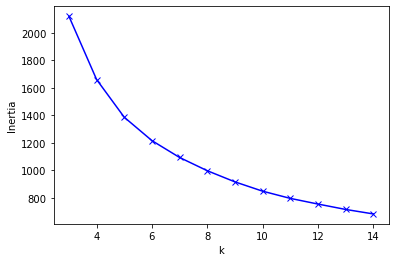

In [15]:
scaler = preprocessing.MinMaxScaler()
features_normal = scaler.fit_transform(df_concatenate_word2vec_git_matc)
inertia = []
K = range(3,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k,init='k-means++', n_init=4, random_state=1).fit(features_normal)
    kmeanModel.fit(features_normal)
    inertia.append(kmeanModel.inertia_)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()


# from sklearn.metrics import silhouette_score
# sil = []
# for k in K:
#     kmeans = KMeans(n_clusters = k,init='k-means++', random_state=7).fit(features_normal) #9
#     labels = kmeans.labels_
#     sil.append(silhouette_score(features_normal, labels, metric = 'cosine'))
# x = K
# y = sil
# plt.plot(x,y)

In [21]:
k=6
kmeanModel =  KMeans(n_clusters=k,init='k-means++', n_init=4, random_state=1).fit(features_normal)

In [24]:
result = result.drop(["stargazers_count", "forks_count", "num_model_file", "updated-created"],axis=1)
result_matc = result_matc.drop(["no_of_comments","no_of_ratings","num_model_file","downloads"],axis=1)
final_frames = [result, result_matc]
final_result = pd.concat(final_frames)

final_result['combined_clusters'] = kmeanModel.labels_
print(final_result['combined_clusters'])
final_result.to_csv("df_final_result.csv")

0       0
1       0
2       0
3       0
4       0
       ..
2587    5
2588    5
2589    5
2590    2
2591    1
Name: combined_clusters, Length: 2808, dtype: int32


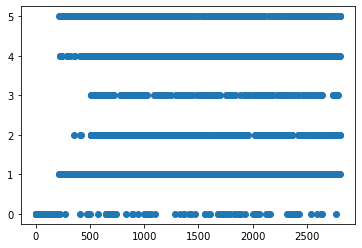

In [25]:
x = [i for i in range(len(final_result['combined_clusters']))]
y = final_result['combined_clusters']
plt.scatter(x,y)


In [19]:
# result = result.drop(["stargazers_count", "forks_count", "num_model_file", "updated-created"],axis=1)
# result.head()

In [20]:


# result_matc.head()